In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from qat.qpus import get_default_qpu
from qat.core import Batch, Job

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.fermion.chemistry.ucc import construct_ucc_ansatz, guess_init_params, get_hf_ket, get_cluster_ops
from qat.qpus import get_default_qpu

from qat.fermion.chemistry.ucc import (
    convert_to_h_integrals,
    transform_integrals_to_new_basis,
)

from qat.plugins import ScipyMinimizePlugin, MultipleLaunchesAnalyzer

In [2]:
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"


In [3]:
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry.ucc import (
    convert_to_h_integrals,
    transform_integrals_to_new_basis,
)
from qat.fermion.chemistry.ucc_deprecated import (
    get_active_space_hamiltonian,
    get_cluster_ops_and_init_guess,
)
from qat.fermion.transforms import (
    get_bk_code,
    get_jw_code,
    get_parity_code,
    recode_integer,
    transform_to_bk_basis,
    transform_to_jw_basis,
    transform_to_parity_basis,
)

from openvqe.common_files.generator_excitations import (
    singlet_gsd,
    singlet_sd,
    singlet_upccgsd,
    spin_complement_gsd,
    spin_complement_gsd_twin,
    uccsd,
)

In [4]:
import numpy as np
from itertools import product
from openvqe.common_files.fermion_util import order_fermionic_term

import scipy.optimize
from qat.fermion.chemistry.ucc_deprecated import build_ucc_ansatz
from qat.lang.AQASM import Program
from qat.qpus import get_default_qpu


def _apply_transforms(cluster_ops_fr, transform, perm=0):
    if transform == "JW":
        transform_func = transform_to_jw_basis
    elif transform == "Bravyi-Kitaev":
        transform_func = transform_to_bk_basis
    elif transform == "parity_basis":
        transform_func = transform_to_parity_basis
    else:
        return
    
    cluster_ops = []
    cluster_ops_sp = []
    for y in cluster_ops_fr:
        hamilt_sp = transform_func(y)
        if hamilt_sp.terms != []:
            cluster_ops.append(y)
            cluster_ops_sp.append(hamilt_sp)
    cluster_ops += cluster_ops * perm
    cluster_ops_sp += cluster_ops_sp * perm
    pool_size = len(cluster_ops_sp)
    return pool_size, cluster_ops, cluster_ops_sp
from qat.core import Term
#from qat.dqs import FermionHamiltonian
from qat.fermion import FermionHamiltonian as Hamiltonian

import numpy as np
from itertools import product
import itertools
from itertools import combinations

from qat.core import Term
#from qat.dqs import FermionHamiltonian
from qat.fermion import FermionHamiltonian as Hamiltonian



def merge_duplicate_terms(hamiltonian):

    """
    Take a fermionic Hamiltonian and merge terms with same operator content

    Parameters
    ----------
    hamiltonian : Hamiltonian
        Of type fermionic cluster operator

    Returns
    ----------
    merged_hamiltonian: Hamiltonian
        The listed merged operators
    
    """
    

    terms = {}

    for term in hamiltonian.terms:

        key = tuple([term.op, tuple(term.qbits)])

        if key in terms.keys():

            terms[key] += term.coeff

        else:

            terms[key] = term.coeff

    terms = [Term(v, k[0], list(k[1])) for k, v in terms.items()]

    merged_hamiltonian = Hamiltonian(
        hamiltonian.nbqbits, terms=terms, constant_coeff=hamiltonian.constant_coeff
    )

    return merged_hamiltonian

import numpy as np
from itertools import product

from qat.core import Term
#from qat.dqs import FermionHamiltonian
from qat.fermion import FermionHamiltonian as Hamiltonian

def permute_fermionic_operator(fermionic_term, ind):
    """
    Perform the permutation of the two operators in index ind and ind + 1 in a fermionic Term pauli string

    Args:
        fermionic_term (Term): the fermionic term which operators we seek to permute
        ind (int): the lower index of the two consecutive creation or annihilation operators we seek to permute
    
    Returns:
        list_terms (list<Term>): the list of fermionic terms resulting of the permutation
    """
    coeff = fermionic_term.coeff
    pauli_op = fermionic_term.op
    qbits = fermionic_term.qbits

    if ind >= len(pauli_op) - 1:
        raise IndexError
    permuted_pauli_op = pauli_op[:ind] + pauli_op[ind + 1] + pauli_op[ind] + pauli_op[ind + 2:]
    permuted_qbits = qbits[:]
    permuted_qbits[ind], permuted_qbits[ind + 1] = permuted_qbits[ind + 1], permuted_qbits[ind]
    if 'c' in pauli_op[ind : ind + 2] and 'C' in pauli_op[ind : ind + 2] and qbits[ind] == qbits[ind + 1]:
        return [Term(coefficient=coeff, pauli_op=pauli_op[: ind] + pauli_op[ind + 2:], qbits=qbits[:ind] + qbits[ind + 2:]), 
                Term(coefficient=-coeff, pauli_op=permuted_pauli_op, qbits=permuted_qbits)]
    else:
        return [Term(coefficient=-coeff ,pauli_op=permuted_pauli_op , qbits=permuted_qbits)]

def order_qubits(fermionic_term):
    """
    Takes a fermionic term which pauli_op is supposed to be ordered properly, and reorder it increasing qbit numbers

    Args:
        fermionic_term (Term): the term to reorder

    Returns:
        ordered_term (Term): the reordered term
    """
    coeff = fermionic_term.coeff
    pauli_op = fermionic_term.op
    qbits = fermionic_term.qbits

    ind_c = pauli_op.index("c")
    qbits_C = qbits[:ind_c]
    qbits_c = qbits[ind_c:]
    new_qbits = []
    
    for qbits_op in [qbits_C, qbits_c]:
        qbits_temp = qbits_op[:]
        ordered = False
        while not ordered:
            ind = 0
            while ind < len(qbits_temp) - 1 and qbits_temp[ind] <= qbits_temp[ind + 1]:
                if qbits_temp[ind] == qbits_temp[ind + 1]:
                    return 
                ind += 1
            if ind < len(qbits_temp) - 1:
                ind += 1
                new_ind = 0
                while qbits_temp[new_ind] < qbits_temp[ind]:
                    new_ind += 1
                elt_not_in_order = qbits_temp.pop(ind)
                qbits_temp.insert(new_ind, elt_not_in_order)
                coeff *= (-1)**(ind - new_ind)
            else:
                ordered = True
        new_qbits += qbits_temp
    return Term(coefficient=coeff, pauli_op=pauli_op, qbits=new_qbits)

def order_fermionic_ops(fermionic_term):
    """
    Order the operators list of a fermionic_term by putting the creations operators on the left and the annihilation operators on the right, with respect to the fermionic anticommutation relations.

    Args:
         fermionic_term (Term): the term to order

    Returns:
        ordered_fermionic_terms (list<Term>): the list of ordered fermionic terms
    """
    coeff = fermionic_term.coeff
    pauli_op = fermionic_term.op
    qbits = fermionic_term.qbits

    ind_c = pauli_op.index('c')
    try:
        ind_C = pauli_op[ind_c:].index('C') + ind_c
    except ValueError:
        new_terms = [fermionic_term]
        ordered_pauli_op = True
    else:
        new_terms = []
        for new_fermionic_term in permute_fermionic_operator(fermionic_term, ind_C - 1):
            new_terms += order_fermionic_term(new_fermionic_term)
    return new_terms

def order_fermionic_term(fermionic_term):
    """
    Order any fermionic term by putting the creation operators on the left, ordered by increasing qubit numbers, and the annihilation operators on the right, ordered y increasing qubit numbers, with respect to the fermionic anticommutation relations.

    Args:
        fermionic_term (Term): the term to order

    Returns:
        ordered_fermionic_terms (list<Term>): the list of ordered fermionic terms
    """
    new_terms = order_fermionic_ops(fermionic_term)
    ordered_terms = []
    for new_term in new_terms:
        ordered_term = order_qubits(new_term)
        if ordered_term:
            ordered_terms.append(ordered_term)
    return ordered_terms

#-----------------------------------------------------------UCCGSD_MAN-----------------------------------------------------------------



from typing import List, Tuple
from qat.core import Term
from qat.fermion import FermionHamiltonian as Hamiltonian

def uccgsd_man(n_elec, orbital_number, transform,
               single_terms: List[List[Tuple[int, str, List[int]]]],
               double_terms: List[List[Tuple[int, str, List[int]]]]):
    """
    Generate fermionic and spin cluster operators for UCC-GSD ansatz.

    Parameters:
    n_elec (int): Number of electrons.
    orbital_number (int): Number of orbitals.
    transform (str): Type of transformation. Either 'JW', 'Bravyi-Kitaev', or 'parity_basis'.
    single_terms (List[List[Tuple[int, str, List[int]]]]): List of single terms for spin complement.
    double_terms (List[List[Tuple[int, str, List[int]]]]): List of double terms for spin complement.

    Returns:
    tuple: (pool_size, cluster_ops, cluster_ops_sp)
    """
    spin_complement_single = []
    spin_complement_double = []

    # Create single terms
    for single_term in single_terms:
        term_objects = [Term(coeff, op, qbits) for coeff, op, qbits in single_term]
        hamiltonian_single = Hamiltonian(2 * orbital_number, term_objects)
        spin_complement_single.append(hamiltonian_single)

    # Create double terms
    for double_term in double_terms:
        term_objects = [Term(coeff, op, qbits) for coeff, op, qbits in double_term]
        hamiltonian_double = Hamiltonian(2 * orbital_number, term_objects)
        spin_complement_double.append(hamiltonian_double)

    spin_complements = spin_complement_single + spin_complement_double
    return _apply_transforms(spin_complements, transform)


#-----------------------------------------------------------UCCGSD-----------------------------------------------------------------



def uccgsd(n_elec, orbital_number, transform):
    """
    TBD

    Parameters
    ----------
    n_elec: int
        The number of electrons

    orbital_number: int
        The number of orbitals
    
    transform: string
        type of transformation. Either 'JW', 'Bravyi-Kitaev', or 'parity_basis'
    
    Returns
    -------

    pool_size: int
        The number of the cluster operators

    cluster_ops: List<Hamiltonian>
        List of fermionic cluster operators
        
    cluster_ops_sp: List<Hamiltonian>
        List of spin cluster operators

    """
    spin_complement_single = []
    spin_complement_double = []

    for p in range(0, 2*orbital_number):
        for q in range(p, 2*orbital_number):
            term_a = [
                    Term(1, "Cc", [p, q]),
                    Term(-1, "Cc", [q, p]),
                ]
            hamiltonian = Hamiltonian(2*orbital_number, term_a)
            spin_complement_single.append(hamiltonian)

            for r in range(p, 2*orbital_number):
                for s in range(q if r==p else r, 2*orbital_number):

                    term_a = [
                        Term(1, "CCcc", [p, q, r, s]),
                        Term(-1, "CCcc", [s, r, q, p]),
                        
                    ]
                    
                    term_a_ordered_terms = map(order_fermionic_term, term_a)
                    term_a = sum(term_a_ordered_terms, [])
                    hamiltonian = Hamiltonian(2*orbital_number, terms=term_a)
                    spin_complement_double.append(hamiltonian)

    spin_complements = spin_complement_single + spin_complement_double
    return _apply_transforms(spin_complements, transform)

#-----------------------------------------------------------UCC-action--------------------------------------------------------------


def ucc_action(theta_current, hamiltonian_sp, cluster_ops_sp, hf_init_sp):
        """
        It maps the exponential of cluster operators ("cluster_ops_sp") associated by their parameters ("theta_current")
        using the CNOTS-staircase method, which is done by "build_ucc_ansatz" which creates the circuit on the top of
        the HF-state ("hf_init_sp"). Then, this function also calculates the expected value of the hamiltonian ("hamiltonian_sp").

        Parameters
        ----------
        theta_current: List<float>
            the Parameters of the cluster operators
        
        hamiltonian_sp: Hamiltonian
                Hamiltonian in the spin representation
            
        cluster_ops_sp: list[Hamiltonian]
            list of spin cluster operators
        
        hf_init_sp: int
            the integer corresponds to the hf_init (The Hartree-Fock state in integer representation) obtained by using
            "qat.fermion.transforms.record_integer".
        
        Returns
        --------
            res.value: float
                the resulted energy

        """
        qpu = 0
        prog = 0
        reg = 0
        qpu = get_default_qpu()
        prog = Program()
        reg = prog.qalloc(hamiltonian_sp.nbqbits)
        qrout = 0
        for n_term, (term, theta_term) in enumerate(zip(cluster_ops_sp, theta_current)):
            init = hf_init_sp if n_term == 0 else 0
            qprog = build_ucc_ansatz([term], init, n_steps=1)
            prog.apply(qprog([theta_term]), reg)
        circ = prog.to_circ()
        return circ


In [5]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code, recode_integer



geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.99))]
basis = "sto-3g"
spin = 0
charge = 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

orbital_number = len(orbital_energies)
nqbits = rdm1.shape[0] * 2

# Wrap the hamiltonian data into the `MolecularHamiltonian` class.
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

molecule = MoleculeInfo(hamiltonian=mol_h, n_electrons=n_electrons, noons = False,  orbital_energies=orbital_energies)
print("The number of qubits are", molecule.nqbits)
print("The number of electrons are", n_electrons)
print("The number of orbitals are", orbital_number)

hpq, hpqrs = convert_to_h_integrals(one_body_integrals, two_body_integrals)

hamiltonian = ElectronicStructureHamiltonian(
    hpq, hpqrs, constant_coeff=nuclear_repulsion
)

hamiltonian_sparse = hamiltonian.get_matrix(sparse=True)

#print(hamiltonian_sparse)

transformation, code = transform_to_jw_basis, get_jw_code

hamiltonian_sp = transformation(hamiltonian)

hamiltonian_sp_sparse = hamiltonian_sp.get_matrix(sparse=True)

#print(hamiltonian_sp_sparse)



/home/huybinh/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


The number of qubits are 4
The number of electrons are 2
The number of orbitals are 2


In [6]:
#-----------------------------------------------------------Hamiltonian / HF-state---------------------------------------------------------------------

n_elec = n_electrons
transform = "JW"

#-----------------------------------------------------------UCCGSD|Man_Input---------------------------------------------------------------------


single_terms_example = [
    [(1, "Cc", [1, 0]), (-1, "Cc", [0, 1])],
    [(1, "Cc", [2, 0]), (-1, "Cc", [0, 2])],
    [(1, "Cc", [3, 0]), (-1, "Cc", [0, 3])],
    [(1, "Cc", [2, 1]), (-1, "Cc", [1, 2])],
    [(1, "Cc", [3, 1]), (-1, "Cc", [1, 3])],
    [(1, "Cc", [3, 2]), (-1, "Cc", [2, 3])]
    # Add more single term configurations as needed
]

double_terms_example = [
    [(1, "CCcc", [0, 1, 2, 3]), (-1, "CCcc", [3, 2, 1, 0])],
    [(1, "CCcc", [0, 2, 1, 3]), (-1, "CCcc", [3, 1, 2, 0])],
    [(1, "CCcc", [0, 3, 1, 2]), (-1, "CCcc", [2, 1, 3, 0])] 

    # Add more double term configurations as needed
]

#pool_size, cluster_ops, cluster_ops_sp = uccgsd_man(n_elec, orbital_number, transform, single_terms_example, double_terms_example)

pool_size, cluster_ops, cluster_ops_sp = uccgsd(n_elec, orbital_number, transform)



In [7]:
#-----------------------------------------------------------UCCGSD|Man_Input---------------------------------------------------------------------


single_terms_example = [
    [(1, "Cc", [1, 0]), (-1, "Cc", [0, 1])],
    [(1, "Cc", [2, 0]), (-1, "Cc", [0, 2])],
    [(1, "Cc", [3, 0]), (-1, "Cc", [0, 3])],
    [(1, "Cc", [2, 1]), (-1, "Cc", [1, 2])],
    [(1, "Cc", [3, 1]), (-1, "Cc", [1, 3])],
    [(1, "Cc", [3, 2]), (-1, "Cc", [2, 3])]
    # Add more single term configurations as needed
]

double_terms_example = [
    [(1, "CCcc", [0, 1, 2, 3]), (-1, "CCcc", [3, 2, 1, 0])],
    [(1, "CCcc", [0, 2, 1, 3]), (-1, "CCcc", [3, 1, 2, 0])],
    [(1, "CCcc", [0, 3, 1, 2]), (-1, "CCcc", [2, 1, 3, 0])] 

    # Add more double term configurations as needed
]

#pool_size, cluster_ops, cluster_ops_sp = uccgsd_man(n_elec, orbital_number, transform, single_terms_example, double_terms_example)

pool_size, cluster_ops, cluster_ops_sp = uccgsd(n_elec, orbital_number, transform)


In [8]:
cluster_ops_sparse = []
for i in cluster_ops_sp:
    cluster_ops_sparse.append(i.get_matrix(sparse=True))
for k in cluster_ops_sparse:
    print(k)


  (4, 8)	(-1+0j)
  (5, 9)	(-1+0j)
  (6, 10)	(-1+0j)
  (7, 11)	(-1+0j)
  (8, 4)	(1+0j)
  (9, 5)	(1+0j)
  (10, 6)	(1+0j)
  (11, 7)	(1+0j)
  (2, 8)	(-1+0j)
  (3, 9)	(-1+0j)
  (6, 12)	(1+0j)
  (7, 13)	(1+0j)
  (8, 2)	(1+0j)
  (9, 3)	(1+0j)
  (12, 6)	(-1+0j)
  (13, 7)	(-1+0j)
  (1, 8)	(-1+0j)
  (3, 10)	(1+0j)
  (5, 12)	(1+0j)
  (7, 14)	(-1+0j)
  (8, 1)	(1+0j)
  (10, 3)	(-1+0j)
  (12, 5)	(-1+0j)
  (14, 7)	(1+0j)

  (2, 4)	(-1+0j)
  (3, 5)	(-1+0j)
  (4, 2)	(1+0j)
  (5, 3)	(1+0j)
  (10, 12)	(-1+0j)
  (11, 13)	(-1+0j)
  (12, 10)	(1+0j)
  (13, 11)	(1+0j)
  (1, 4)	(-1+0j)
  (3, 6)	(1+0j)
  (4, 1)	(1+0j)
  (6, 3)	(-1+0j)
  (9, 12)	(-1+0j)
  (11, 14)	(1+0j)
  (12, 9)	(1+0j)
  (14, 11)	(-1+0j)

  (1, 2)	(-1+0j)
  (2, 1)	(1+0j)
  (5, 6)	(-1+0j)
  (6, 5)	(1+0j)
  (9, 10)	(-1+0j)
  (10, 9)	(1+0j)
  (13, 14)	(-1+0j)
  (14, 13)	(1+0j)












  (10, 12)	(1+0j)
  (11, 13)	(1+0j)
  (12, 10)	(-1+0j)
  (13, 11)	(-1+0j)
  (9, 12)	(1+0j)
  (11, 14)	(-1+0j)
  (12, 9)	(-1+0j)
  (14, 11)	(1+0j)

  (6, 12)	(1

In [9]:
print(len(cluster_ops))

cluster_shift = []
for i in cluster_ops_sp:
    print(i)
    if i != 0:
        cluster_shift.append(i*1j)
        
print(len(cluster_shift))    
cluster_ops_sp = cluster_shift

65

-0.5j * (YX|[0, 1]) +
0.5j * (XY|[0, 1])
-0.5j * (YZX|[0, 1, 2]) +
0.5j * (XZY|[0, 1, 2])
-0.5j * (YZZX|[0, 1, 2, 3]) +
0.5j * (XZZY|[0, 1, 2, 3])

-0.5j * (YX|[1, 2]) +
0.5j * (XY|[1, 2])
-0.5j * (YZX|[1, 2, 3]) +
0.5j * (XZY|[1, 2, 3])

-0.5j * (YX|[2, 3]) +
0.5j * (XY|[2, 3])












-0.25j * (ZYX|[0, 1, 2]) +
0.25j * (YX|[1, 2]) +
0.25j * (ZXY|[0, 1, 2]) +
-0.25j * (XY|[1, 2])
-0.25j * (ZYZX|[0, 1, 2, 3]) +
0.25j * (YZX|[1, 2, 3]) +
0.25j * (ZXZY|[0, 1, 2, 3]) +
-0.25j * (XZY|[1, 2, 3])

0.25j * (YX|[0, 2]) +
-0.25j * (YZX|[0, 1, 2]) +
-0.25j * (XY|[0, 2]) +
0.25j * (XZY|[0, 1, 2])
0.25j * (YZX|[0, 2, 3]) +
-0.25j * (YZZX|[0, 1, 2, 3]) +
-0.25j * (XZY|[0, 2, 3]) +
0.25j * (XZZY|[0, 1, 2, 3])

0.125j * (YYYX|[0, 1, 2, 3]) +
-0.125j * (XXYX|[0, 1, 2, 3]) +
-0.125j * (YXYY|[0, 1, 2, 3]) +
(-0-0.125j) * (XYYY|[0, 1, 2, 3]) +
0.125j * (YXXX|[0, 1, 2, 3]) +
0.125j * (XYXX|[0, 1, 2, 3]) +
0.125j * (YYXY|[0, 1, 2, 3]) +
-0.125j * (XXXY|[0, 1, 2, 3])


-0.25j * (ZYX|[0, 2, 3]) +
0.2

In [10]:
ket_hf_init = get_hf_ket(molecule.n_electrons, nqbits=molecule.nqbits)
hf_init_sp = recode_integer(ket_hf_init, code(nqbits))

ket_hf = binary_repr(hf_init_sp)
list_ket_hf = [int(c) for c in ket_hf]

# list_ket_hf: [1, 1, 0, 0]

state_vector = [1]
for i in list_ket_hf:
    qubit_vector = [not i, i]
    state_vector = np.kron(state_vector, qubit_vector)
    #print(state_vector)

# state_vector: 
#[0 1]
#[0 0 0 1]
#[0 0 0 0 0 0 1 0]
#[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]

sparse_reference_state = scipy.sparse.csr_matrix(
    state_vector, dtype=complex
).transpose()

# sparse_reference_state
# (12, 0)	(1+0j)


In [11]:
#--------------------------HF-state calcultation-----------------------------------------------------------------
def prepare_hf_state(hf_init_sp, cluster_ops_sp):
    """
    It constructs the Hartree-Fock state (ansatz)

    Parameters
    ----------

    hf_init_sp: int
        the integer corresponds to the hf_init (The Hartree-Fock state in integer representation) obtained by using
        "qat.fermion.transforms.record_integer".

    cluster_ops_sp: list[Hamiltonian]
        list of spin cluster operators
    

    Returns
    --------
        circuit: qat.core.Circuit
            the circuit representing the HF-state
    
    """
    prog = Program()
    nbqbits = cluster_ops_sp[0].nbqbits
    ket_hf = binary_repr(hf_init_sp)
    list_ket_hf = [int(c) for c in ket_hf]
    qb = prog.qalloc(nbqbits)
    for j in range(nbqbits):
        if int(list_ket_hf[j] == 1):
            prog.apply(X, qb[j])
    circuit = prog.to_circ()
    return circuit


def hf_energy(hf_state, hamiltonian_sp):
    """
    Returns the Hartee Fock energy

    Parameters
    ----------

    hf_state: qat.core.Circuit
        the circuit representing the HF state

    hamiltonian_sp: Hamiltonian
        Hamiltonian in the spin representation

    
    Returns
    --------
        res.value: float
            the resulted energy

    """
    qpu = get_default_qpu()
    res = qpu.submit(hf_state.to_job(job_type="OBS", observable=hamiltonian_sp))
    return res.value


hf_state = prepare_hf_state(hf_init_sp, cluster_ops_sp)

ref_energy = hf_energy(hf_state, hamiltonian_sp)
print(ref_energy)

-1.0688975010368331


In [12]:
def commutators_calculations(cluster_ops_sp, hamiltonian_sp):
    """
    Compute the commutators [cluster_ops_sp[i], hamiltonian_sp].
    Note: it is under developement

    Parameters
    -----------

    cluster_ops_sp: list[Hamiltonian]
        list of spin cluster operators
    
    hamiltonian_sp: Hamiltonian
        Hamiltonian in the spin representation
    

    Returns
    --------
    list_commutators: list<float>
        list of the resulting commutators (gradients)

    """

    list_commutators = []
    for oi in cluster_ops_sp:
        X = -(
            hamiltonian_sp * oi * (complex(0, 1))
            - oi * (complex(0, 1)) * hamiltonian_sp
        )
        list_commutators.append(X)
    return list_commutators

list_commute = commutators_calculations(cluster_ops_sp, hamiltonian_sp)
#print(list_commute)
for i in list_commute:
    print(i)




(-0.049039494749704995+0j) * (ZYY|[0, 2, 3]) +
(0.049039494749704995+0j) * (ZXX|[1, 2, 3]) +
(0.04903949474970498+0j) * (YYZ|[0, 1, 2]) +
(0.04903949474970498+0j) * (XXZ|[0, 1, 2]) +
(-0.04903949474970498+0j) * (YYZ|[0, 1, 3]) +
(-0.04903949474970498+0j) * (XXZ|[0, 1, 3]) +
(0.049039494749704995+0j) * (ZYY|[1, 2, 3]) +
(-0.049039494749704995+0j) * (ZXX|[0, 2, 3])
(-0.0012453336668223347+0j) * (YY|[0, 2]) +
(-0.0012453336668223347+0j) * (XX|[0, 2]) +
(0.007868832996939745+0j) * (YZYZ|[0, 1, 2, 3]) +
(-0.2714544780592856+0j) * (YZY|[0, 1, 2]) +
(-0.09807898949940999+0j) * (XX|[1, 3]) +
(-0.09807898949940999+0j) * (YY|[1, 3]) +
(0.09807898949940999+0j) * (ZXZX|[0, 1, 2, 3]) +
(0.09807898949940999+0j) * (ZYZY|[0, 1, 2, 3]) +
(0.007868832996939745+0j) * (XZXZ|[0, 1, 2, 3]) +
(-0.2714544780592856+0j) * (XZX|[0, 1, 2])
(-0.049039494749704995+0j) * (ZXX|[0, 1, 2]) +
(0.049039494749704995+0j) * (YYZ|[1, 2, 3]) +
(-0.050284828416527316+0j) * (YZY|[0, 2, 3]) +
(0.05690832774664473+0j) * (YZY|[0, 

In [13]:
print('length of the cluster OP: ', len(cluster_ops))
print('length of the cluster OPS: ', len(cluster_ops_sp))
print('length of the cluster _sparse: ', len(cluster_ops_sp))

length of the cluster OP:  65
length of the cluster OPS:  21
length of the cluster _sparse:  21


In [14]:
curr_state = hf_state

In [15]:
import numpy as np
n_steps =1 
prog = Program()

model = hamiltonian_sp

theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(len(cluster_ops_sp) * n_steps)]
theta = [prog.new_var(float, f"\\theta_{i}") for i in range(len(theta_0))]

print("The initial HF state ", hf_init_sp)

#k_lst = [6, 10, hf_init_sp] # List of the excitation
#k_lst = [12, 10, 6]

circ = ucc_action(theta, model, cluster_ops_sp, hf_init_sp)


# Create and store circuits in a list
circuits_store = [circ]
    

# Display the circuits
for circ_dis in circuits_store:
    circ_dis.display()

print(len(theta_0))
# The circuits_store[0] should be the initial HF state

The initial HF state  12


21


In [16]:
curr_state = hf_state
curr_state_open_f = 1.0 * sparse_reference_state
prev_norm = 0.0

def prepare_hf_state(hf_init_sp, cluster_ops_sp):


    prog = Program()
    nbqbits = cluster_ops_sp[0].nbqbits
    ket_hf = binary_repr(hf_init_sp)
    list_ket_hf = [int(c) for c in ket_hf]
    qb = prog.qalloc(nbqbits)
    for j in range(nbqbits):
        if int(list_ket_hf[j] == 1):
            prog.apply(X, qb[j])
    circuit = prog.to_circ()
    return circuit


In [17]:
#-----------------------------------------------------------current-state-peparation--------------------------------------------------------------

def prepare_state_ansatz(cluster_ops_sp, hf_init_sp, parameters):


    prog = Program()
    reg = prog.qalloc(cluster_ops_sp[0].nbqbits)
    for n_term, (term, theta_term) in enumerate(zip(cluster_ops_sp, parameters)):
        init = hf_init_sp if n_term == 0 else 0
        qprog = build_ucc_ansatz([term], init, n_steps=1)
        prog.apply(qprog([theta_term]), reg)
    circ = prog.to_circ()
    curr_state = circ
    return curr_state

#-----------------------------------------------------------gradient Optimization--------------------------------------------------------------

def compute_gradient_i(i, cluster_ops_sparse, v, sig):

    op_a = cluster_ops_sparse[i]
    gi = 2 * (sig.transpose().conj().dot(op_a.dot(v)))
    assert gi.shape == (1, 1)
    gi = gi[0, 0]
    # print('gi values are: ', gi)
    assert np.isclose(gi.imag, 0)
    gi = gi.real
    return gi

def return_gradient_list(cluster_ops_sparse, hamiltonian_sparse, curr_state):
    
    list_grad = []
    curr_norm = 0
    next_deriv = 0
    next_index = 0
    sig = hamiltonian_sparse.dot(curr_state)
    for oi in range(len(cluster_ops_sparse)):
        gi = compute_gradient_i(oi, cluster_ops_sparse, curr_state, sig)
        list_grad.append(abs(gi))
        curr_norm += gi * gi
        if abs(gi) > abs(next_deriv):
            next_deriv = gi
            next_index = oi
    return list_grad, curr_norm, next_deriv, next_index




In [19]:
def gradient_funct(cluster_ops_sp, hf_init_sp, parameters, hamiltonian_sparse): # Problem running this cell
    prog = Program()
    reg = prog.qalloc(cluster_ops_sp[0].nbqbits)

    # State preparation
    for n_term, (term, theta_term) in enumerate(zip(cluster_ops_sp, parameters)):
        init = hf_init_sp if n_term == 0 else 0
        qprog = build_ucc_ansatz([term], init, n_steps=1)
        prog.apply(qprog([theta_term]), reg)
    curr_state = prog.to_circ()

    # Gradient optimization
    list_grad = []
    curr_norm = 0
    next_deriv = 0
    next_index = 0
    sig = hamiltonian_sparse.dot(curr_state)
    for oi in range(len(cluster_ops_sp)):
        op_a = cluster_ops_sp[oi]
        gi = 2 * (sig.transpose().conj().dot(op_a.dot(curr_state)))
        assert gi.shape == (1, 1)
        gi = gi[0, 0]
        assert np.isclose(gi.imag, 0)
        gi = gi.real

        list_grad.append(abs(gi))
        curr_norm += gi * gi
        if abs(gi) > abs(next_deriv):
            next_deriv = gi
            next_index = oi

    return curr_state, list_grad, curr_norm, next_deriv, next_index


calcul  =  gradient_funct(cluster_ops_sp, hf_init_sp, theta, hamiltonian_sparse)

TypeError: unsupported operand type(s) for @: 'csr_matrix' and 'Circuit'

In [ ]:


#-----------------------------------------------------------current-state-peparation--------------------------------------------------------------

def prepare_state_ansatz(cluster_ops_sp, hf_init_sp, parameters):


    prog = Program()
    reg = prog.qalloc(cluster_ops_sp[0].nbqbits)
    for n_term, (term, theta_term) in enumerate(zip(cluster_ops_sp, parameters)):
        init = hf_init_sp if n_term == 0 else 0
        qprog = build_ucc_ansatz([term], init, n_steps=1)
        prog.apply(qprog([theta_term]), reg)
    circ = prog.to_circ()
    curr_state = circ
    return curr_state

#-----------------------------------------------------------gradient Optimization--------------------------------------------------------------

def compute_gradient_i(i, cluster_ops_sparse, v, sig):

    op_a = cluster_ops_sparse[i]
    gi = 2 * (sig.transpose().conj().dot(op_a.dot(v)))
    assert gi.shape == (1, 1)
    gi = gi[0, 0]
    # print('gi values are: ', gi)
    assert np.isclose(gi.imag, 0)
    gi = gi.real
    return gi

def return_gradient_list(cluster_ops_sparse, hamiltonian_sparse, curr_state):
    
    list_grad = []
    curr_norm = 0
    next_deriv = 0
    next_index = 0
    sig = hamiltonian_sparse.dot(curr_state)
    for oi in range(len(cluster_ops_sparse)):
        gi = compute_gradient_i(oi, cluster_ops_sparse, curr_state, sig)
        list_grad.append(abs(gi))
        curr_norm += gi * gi
        if abs(gi) > abs(next_deriv):
            next_deriv = gi
            next_index = oi
    return list_grad, curr_norm, next_deriv, next_index

#-----------------------------------------------------------State vector implementation--------------------------------------------------------------

def get_statevector_matrix(result, nqbits):
    statevector_mat = np.zeros((2**nqbits), np.complex128)
    for sample in result:
        statevector_mat[sample.state.int] = sample.amplitude
    return statevector_mat


def overlap(circ, def_stv):
    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector_matrix(res, nqbits)
    
    # Check if the statevector is not None
    if statevector is not None:
        overlap_vals = abs(np.vdot(def_stv, statevector)) ** 2
        return overlap_vals
    else:
        return 0

def QKDOptimizer(circuits, model, qpu, nqbits, k = 1, betas = [], theta_0 = [], method = "BFGS", maxiter = 3000, gtol = 1e-5):
    
    stv_mats = []
    options = {"disp": True, "maxiter": maxiter, "gtol": gtol}
    
    for _ in range(k):
        
        energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits))}
        
        # define input function
        def input_funct(x):
            total_energy = 0
            for i, circ in enumerate(circuits):
                
                bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
                job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
                result = qpu.submit(job_exci_inp)

                total_energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(total_energy)
                for j in range(len(stv_mats)):
                    overlap_inp = overlap(bound_circ, stv_mats[j])
                    total_energy += betas[j] * overlap_inp
                
            return total_energy

        # callback function
        def callback(x):
            for i, circ in enumerate(circuits):
                
                bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
                job_exci_inp = bound_circ.to_job(job_type="OBS", observable=model, nbshots=0)
                result = qpu.submit(job_exci_inp)

                energy = result.value
                energy_lists[f"energy_circ_{i}"][method].append(energy)
        
        Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)
        
        # plot engery
        #print("The first excited energy state", Optimizer.fun)
        for i in range(len(circuits)):
            energies = energy_lists[f"energy_circ_{i}"][method]
            plt.plot(range(len(energies)), energies, color='crimson')
            print("The state energy value is ", energies[-1])
        plt.xlabel("Iterations")
        plt.ylabel("Energy")
        plt.title("Energy Evolution")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
        plt.grid(True)
        plt.show()
        
        opt_circ = circuits[0].bind_variables({k: v for k, v in zip(sorted(circuits[0].get_variables()), Optimizer.x)})
        result = qpu.submit(opt_circ.to_job())
        stv_mats.append(get_statevector_matrix(result, nqbits))
        
        


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: -1.103248
         Iterations: 16
         Function evaluations: 462
         Gradient evaluations: 21
The state energy value is  -1.1032476611772153


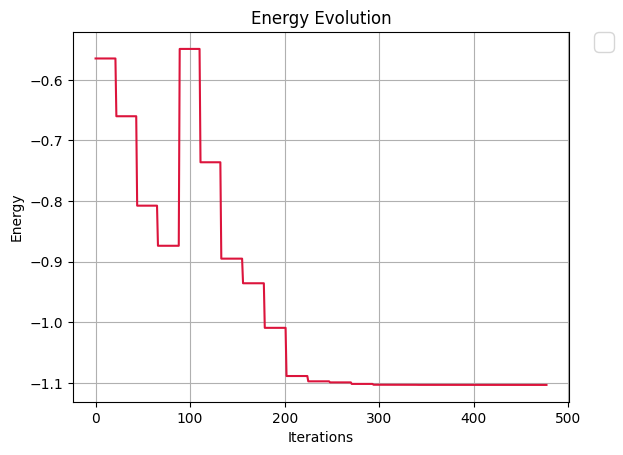

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: -0.740375
         Iterations: 11
         Function evaluations: 308
         Gradient evaluations: 14
The state energy value is  -0.7403748572451166


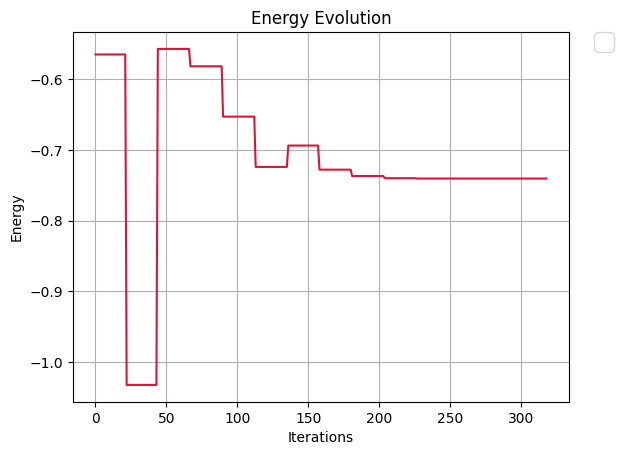

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: -0.740375
         Iterations: 19
         Function evaluations: 550
         Gradient evaluations: 25
The state energy value is  -0.7403748572472458


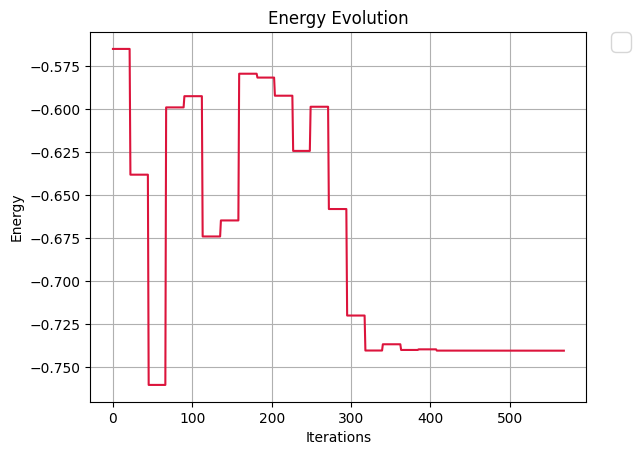

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Optimization terminated successfully.
         Current function value: -0.740375
         Iterations: 20
         Function evaluations: 660
         Gradient evaluations: 30
The state energy value is  -0.7403748572475909


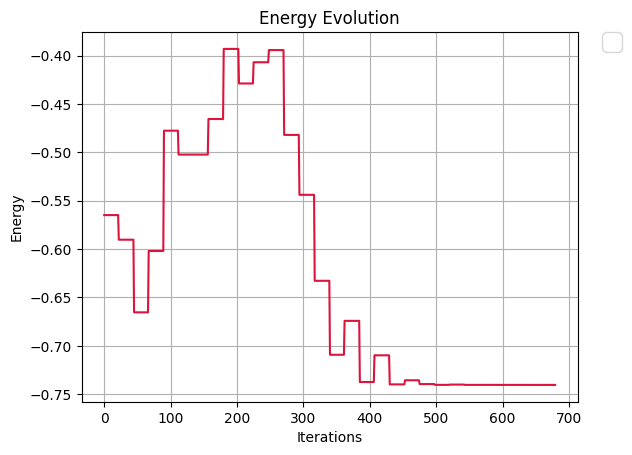

KeyboardInterrupt: 

In [ ]:
qpu = get_default_qpu()
method = "BFGS"
model = hamiltonian_sp
nqbits = model.nbqbits
circuits = circuits_store

QKDOptimizer(circuits, model, qpu, nqbits, k = 6, betas = [33,44,55,66,88], theta_0 = theta_0)